# Accuracy optimization of the DFT U-net

We demonstrate that a pure scalability can be reached for both the 1nn and 2nn system. However we can reach accuracies that can be considered low (rel err$=10^{-3}$). For this reason we wonder if we can force the CNN to outperform by increasing the learning capacity in both hidden channels, kernel size and convolutional blocks (without pooling).

We consider the 2nn case in the critical point and two datasets with $1.5 \cdot 10^3$ and $1.5 \cdot 10^4$ sample.



#### Imports

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import test_models_unet

## Case a) U-Net with pooling incresing the number of Hidden channels

#### Data

In [93]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock','2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 80]_hc_5_ks_2_ps_2_nconv_0_nblock','2nn_ising/h_5.44_15k_unet_periodic_augmentation_[80, 160]_hc_5_ks_2_ps_2_nconv_0_nblock']

data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*3

hc=[20,40,80]

ls=[128]*3

#### Accuracy analysis

In [94]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


REDENT(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 20, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
      (pooling 1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): Sequential(
      (conv2): Conv1d(20, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
      (pooling 2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): ConvTranspose1d(40, 20, kernel_size=(6,), stride=(2,), padding=(2,))
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): ConvTranspose1d(20, 1, kernel_size=(6,), stride=(2,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=9101
R_square_test=0.9998987913131714 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock 

de=0.000573943

#### Plots

$R^2$

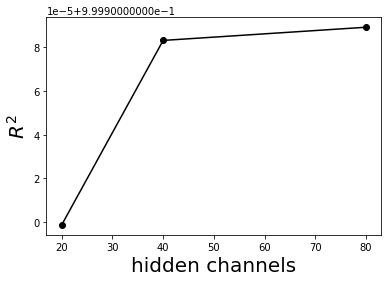

In [95]:
plt.plot([20,40,80],r,color='black',marker='o')
plt.xlabel('hidden channels',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

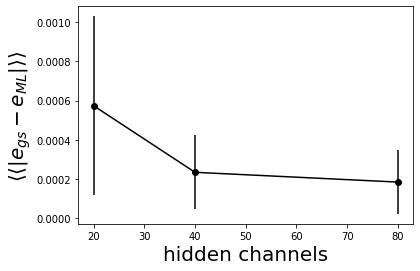

In [96]:
plt.errorbar([20,40,80],de,yerr=devde,color='black',marker='o')
plt.xlabel('hidden channels',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [20]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(hc)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]
    

#### Plots

()


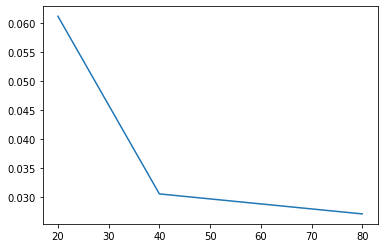

In [21]:
print(g_acc[0].shape)
plt.plot(hc,g_acc)
plt.show()

## Case b) U-Net without pooling incresing the kernel size

#### Data

In [22]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_1_ks_2_ps_2_nconv_0_nblock','2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_3_ks_2_ps_2_nconv_0_nblock','2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock',
'2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_7_ks_2_ps_2_nconv_0_nblock']

data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*4

ks=[1,3,5,7]

ls=[16]*4

#### Accuracy analysis

In [23]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

REDENT(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 20, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
      (pooling 1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (1): Sequential(
      (conv2): Conv1d(20, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation_2): GELU()
      (pooling 2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): ConvTranspose1d(40, 20, kernel_size=(2,), stride=(2,))
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): ConvTranspose1d(20, 1, kernel_size=(2,), stride=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
)
# parameters=2541
R_square_test=0.9896542429924011 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[20, 40]_hc_1_ks_2_ps_2_nconv_0_nblock 

de=0.00631862403348602 std(de)=0.00463064602942907
REDENT(
  (conv_dow

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


#### Plots

$R^2$

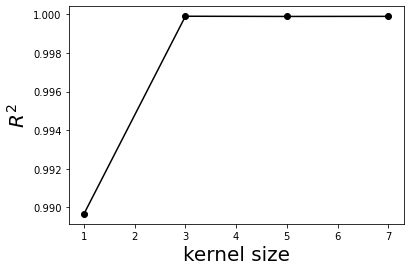

In [26]:
plt.plot(ks,r,color='black',marker='o')
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

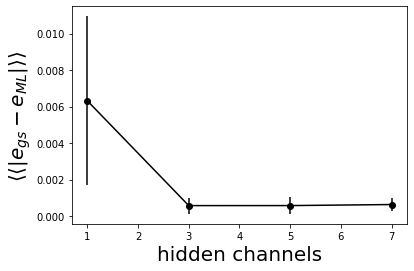

In [28]:
plt.errorbar(ks,de,yerr=devde,color='black',marker='o')
plt.xlabel('hidden channels',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [35]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(ks)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]
    

#### Plots

()


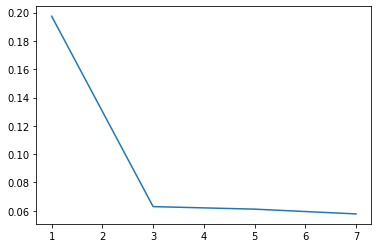

In [36]:
print(g_acc[0].shape)
plt.plot(ks,g_acc)
plt.show()

## Case c) U-Net without pooling size: a study for different kernel sizes

#### Data

In [67]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_1_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_3_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_7_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_9_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_11_ks_1_ps_2_nconv_0_nblock']


ks=[1,3,5,7,9,11]

ls=[16]*len( ks)


data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*len(ks)

#### Accuracy

In [68]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(1,), stride=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(1,), stride=(1,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=3401
R_square_test=0.9303698539733887 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_1_ks_1_ps_2_nconv_0_nblock 

de=0.01704405142089355 std(de)=0.011814007805344107
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(3,), stride=(1,

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


$R^2$

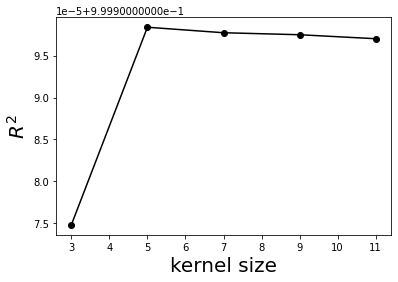

In [69]:
plt.plot(ks[1:],r[1:],color='black',marker='o')

plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

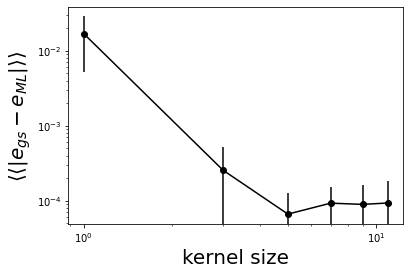

In [70]:
plt.errorbar(ks,de,yerr=devde,color='black',marker='o')
plt.loglog()
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Accuracy

In [71]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(ks)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]

#### Plot

()


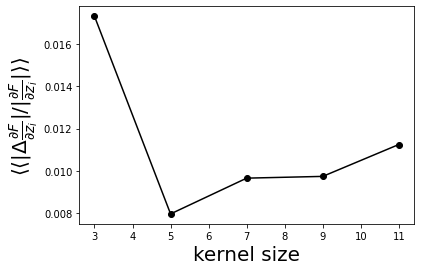

In [73]:
print(g_acc[0].shape)
plt.plot(ks[1:],g_acc[1:],color='black',marker='o')
plt.xlabel('kernel size',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.show()

## Case b) U-Net without pooling incresing the number of convolutional blocks

#### Data

In [133]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40]_hc_5_ks_1_ps_3_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40, 40]_hc_5_ks_1_ps_5_nconv_0_nblock',
             ]


blocks=np.arange(4)

ls=[16]*len( blocks)


data_path=['data/dataset_2nn/test_unet_periodic_2nn_16_l_5.44_h_100_n.npz']*len(blocks)

#### Accuracy

In [134]:
r,de,devde=test_models_unet(models_name=models_name,data_path=data_path)

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=16521
R_square_test=0.9999983906745911 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=6.589498515328067e-05 std(de)=6.120556790270633e-05
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequentia

$R^2$

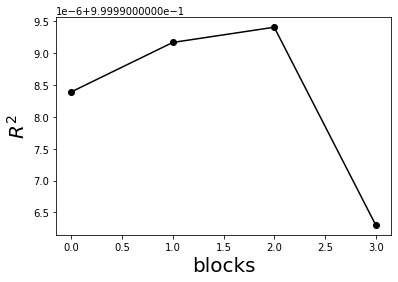

In [135]:
plt.plot(blocks,r,color='black',marker='o')

plt.xlabel('blocks',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.show()

Energy

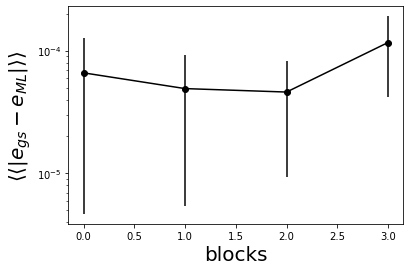

In [137]:
plt.errorbar(blocks,de,yerr=devde,color='black',marker='o')
plt.semilogy()
plt.xlabel('blocks',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Accuracy

In [138]:
ndata=100
ms = []
vs = []
g_acc = []
pseudo_pot = []
v_acc = []
models = []
for i in range(len(blocks)):
    data=np.load(data_path[i])
    m=data['density']
    v=data['potential']
    ms.append(m)
    vs.append(v)
    model=torch.load(
        "model_rep/"+models_name[i],
        map_location="cpu",
    )
    models.append(model)
    x = m[:ndata]
    x = torch.tensor(x, dtype=torch.double)
    x.requires_grad_(True)
    f = torch.mean(model(x), dim=-1)
    # print(f.shape)
    f.backward(torch.ones_like(f))
    with torch.no_grad():
        grad = x.grad
        grad = -ls[i] * grad.detach().numpy()
        pseudo_pot = grad
    # print(grad.shape)
    v_acc = np.sqrt(np.average((grad - vs[:ndata]) ** 2, axis=-1)) / np.sqrt(
        np.average((v[:ndata]) ** 2, axis=-1)
    )
    g_acc.append(
        np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
        / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
    )

g_acc = [np.average(g) for g in g_acc]

#### Plot

()


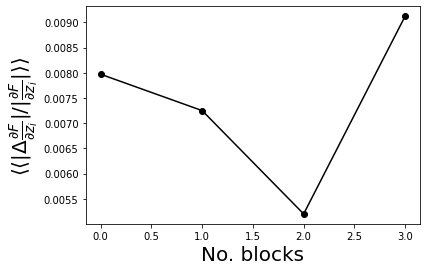

In [139]:
print(g_acc[0].shape)
plt.plot(blocks,g_acc,color='black',marker='o')
plt.xlabel('No. blocks',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.show()

## Scalability Performance for different Kernel Size

#### Data

In [151]:
ls=[16,128,256]
data_path=[f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_3_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_7_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_9_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_11_ks_1_ps_2_nconv_0_nblock']

ks=[3,5,7,9,11]


#### Accuracy

In [152]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)    

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=9961
R_square_test=0.99997478723526 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_3_ks_1_ps_2_nconv_0_nblock 

de=0.0002542893707701718 std(de)=0.00025757720312498264
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(

$R^2$

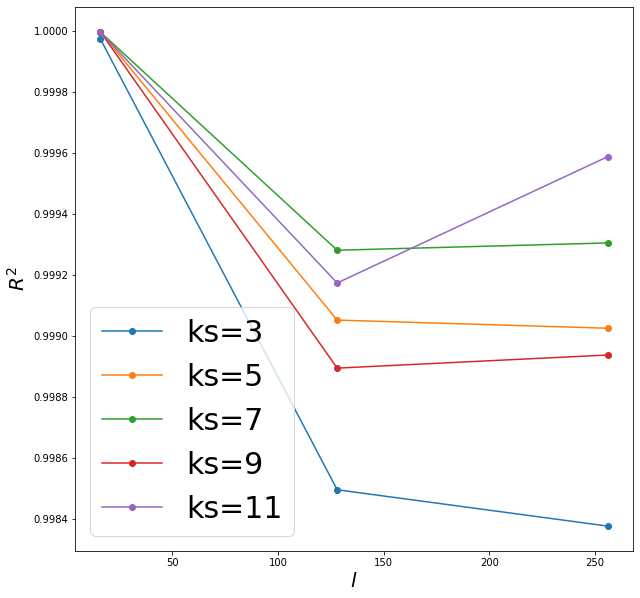

In [153]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'ks={ks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

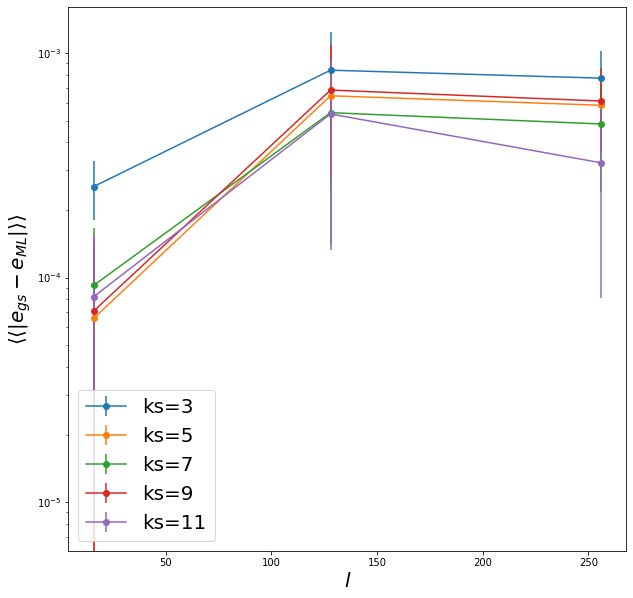

In [154]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'ks={ks[i]}')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Analysis

In [155]:
ndata=100
g_accs=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

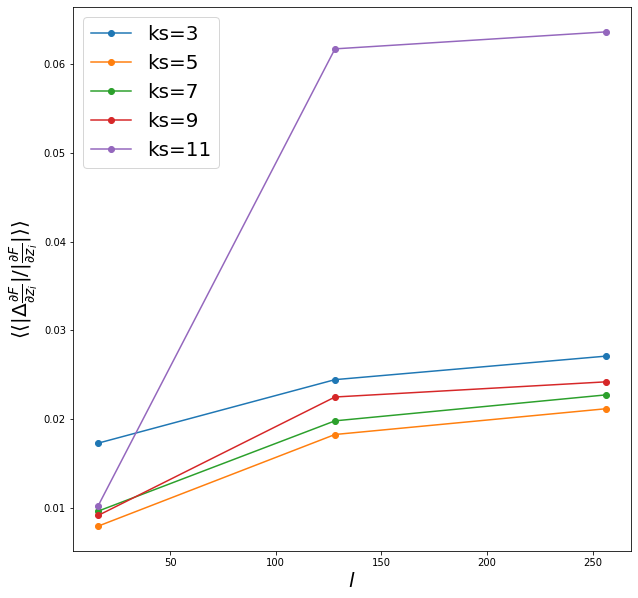

In [156]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,g_accs[i],marker='o',label=f'ks={ks[i]}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Scalability analysis at different Depth of the Neural Network

#### Data

In [2]:
models_name=['2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40]_hc_5_ks_1_ps_3_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40]_hc_5_ks_1_ps_4_nconv_0_nblock',
             '2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40, 40, 40, 40]_hc_5_ks_1_ps_5_nconv_0_nblock',
             ]


blocks=np.arange(4)

ls=[16,128,256]


data_path=[f'data/dataset_2nn/test_unet_periodic_2nn_{l}_l_5.44_h_100_n.npz' for l in ls]

#### Accuracy

In [8]:
rs=[]
des=[]
devdes=[]
for i in range(len(models_name)):
    r,de,devde=test_models_unet(models_name=[models_name[i]]*len(data_path),data_path=data_path)
    rs.append(r)
    des.append(de)
    devdes.append(devde)  

/home/ecosta/dft_for_ising/src/training/utils_analysis.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy = Energy_unet(model, pt.tensor(v, dtype=pt.double))


REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_2): GELU()
    )
  )
  (conv_upsample): ModuleList(
    (0): Sequential(
      (trans_conv1): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (trans_conv2): Conv1d(40, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    )
  )
  (Activation): GELU()
  (loss): MSELoss()
  (loss_dft): MSELoss()
)
# parameters=16521
R_square_test=0.9999983906745911 for 2nn_ising/h_5.44_15k_unet_periodic_augmentation_[40, 40]_hc_5_ks_1_ps_2_nconv_0_nblock 

de=6.589498515328067e-05 std(de)=6.120556790270633e-05
REDENTnopooling(
  (conv_downsample): ModuleList(
    (0): Sequentia

$R^2$

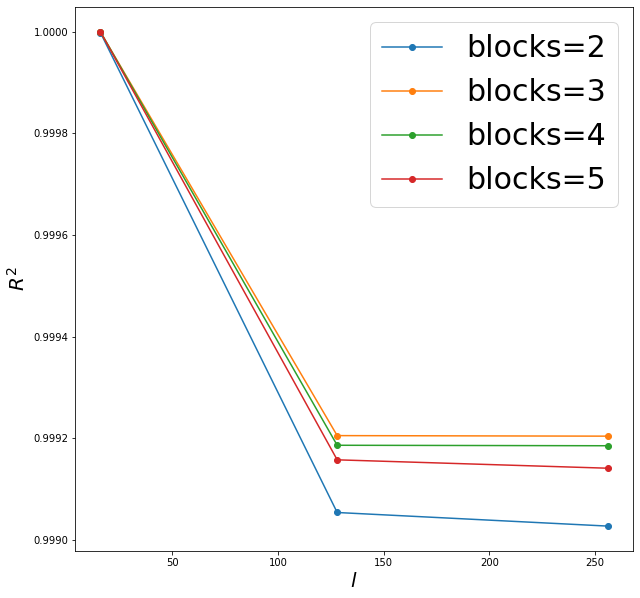

In [4]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,rs[i],marker='o',label=f'blocks={blocks[i]+2}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$R^2$',fontsize=20)
plt.legend(fontsize=30)
plt.show()

Energy

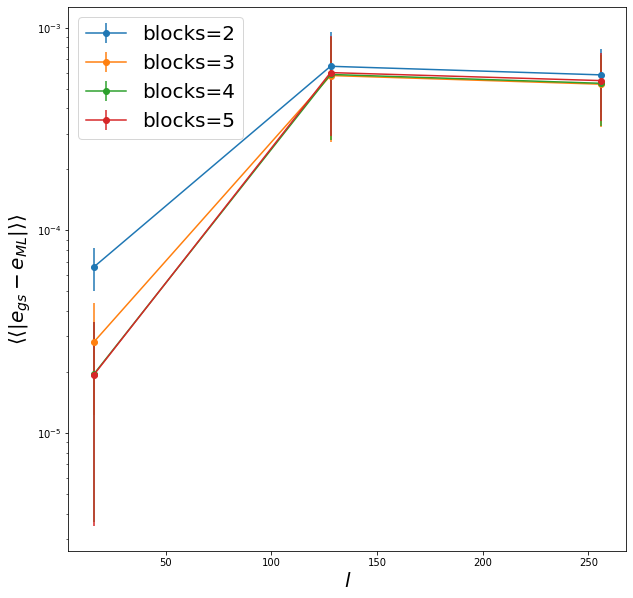

In [5]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.errorbar(ls,des[i],yerr=devde,marker='o',label=f'blocks={blocks[i]+2}')
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle|e_{gs}-e_{ML}| \rangle \rangle$',fontsize=20)
plt.show()

#### Gradient Descent Accuracy

In [6]:
ndata=100
g_accs=[]
for j in range(len(models_name)):
    g_acc = []
    for i in range(len(ls)):
        data=np.load(data_path[i])
        m=data['density']
        v=data['potential']
        model=torch.load(
            "model_rep/"+models_name[j],
            map_location="cpu",
        )
        x = m[:ndata]
        x = torch.tensor(x, dtype=torch.double)
        x.requires_grad_(True)
        f = torch.mean(model(x), dim=-1)
        # print(f.shape)
        f.backward(torch.ones_like(f))
        with torch.no_grad():
            grad = x.grad
            grad = -ls[i] * grad.detach().numpy()
            pseudo_pot = grad
        # print(grad.shape)
        g_acc.append(
            np.sqrt(np.average((grad - v[:ndata]) ** 2, axis=-1))
            / np.sqrt(np.average((v[:ndata]) ** 2, axis=-1))
        )

    g_acc = [np.average(g) for g in g_acc]
    g_accs.append(g_acc)

#### Plots

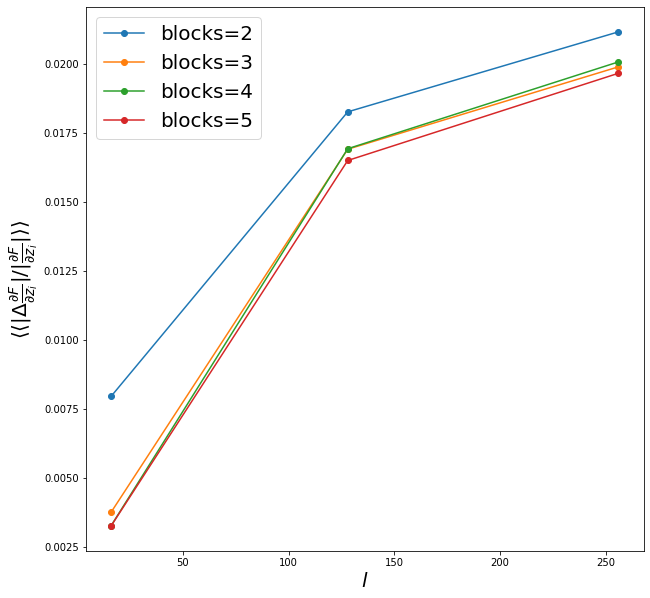

In [7]:
plt.figure(figsize=(10,10))
for i in range(len(models_name)):
    plt.plot(ls,g_accs[i],marker='o',label=f'blocks={blocks[i]+2}')
plt.xlabel(r'$l$',fontsize=20)
plt.ylabel(r'$\langle \langle |\Delta \frac{\partial F}{\partial z_i} |/|\frac{\partial F}{\partial z_i}| \rangle \rangle$',fontsize=20)
plt.legend(fontsize=20)
plt.show()